In [1]:
import cv2 as cv
from matplotlib.pyplot import imshow, show, figure
import imutils
import numpy as np

def cv2_imshow(image, figsize=(3,3)):
    fig = figure(figsize=figsize)
    try:
        imshow(image[:,:,::-1])
    except IndexError:
        imshow(image, cmap="gray")
    show()

In [42]:
def extract_corners(filename):
    kernel = np.ones((3,3),np.uint8)
    #Read original image and grayscale
    img_original = cv.imread(filename)
    img = cv.cvtColor(cv.imread(filename), cv.COLOR_BGR2GRAY)
    img_copy = img.copy()
    
    #Transform in black and white
    imgt = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV,57,3)
    
    imgt_copy = imgt.copy()
    #Find external countour, create mask and draw external countour on mask
    contours, hierarchy = cv.findContours(image=imgt_copy, mode=cv.RETR_EXTERNAL, method=cv.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(imgt)
    max_c = 0
    max_area = 0
    for contorno in contours:
        c_area = cv.contourArea(contorno)
        if c_area > max_area:
            max_area = c_area
            max_c = contorno
    cv.drawContours(image=mask, contours=[max_c], contourIdx=-1, color=(255), thickness=2, lineType=cv.LINE_AA)
    corners = []
    for i in np.linspace(1, 0, 20): # Busca de melhor parâmetro
        #Find grid corners and draw on original image
        corners = cv.goodFeaturesToTrack(mask, 4, i, 50)
        if corners is None: continue
        for corner in corners:
            x,y = corner.ravel().astype(int)
            cv.circle(img_original, (x,y), 5, (36,255,12), -1)
        corners = sorted(corners.copy().astype(np.float32).reshape(corners.shape[0], corners.shape[2]), key=lambda x: x[0])
        if len(corners) == 4:
            break
    # Magical for-else loop, only enters else if finish loop without break
    else:
        raise Exception("Unable to find corners for supplied image! Are you sure it's a valid sudoku?")
    pts1 = []
    a,b,c,d = corners
    if a[1]>b[1]:
        pts1.append(list(a))
        pts1.append(list(b))
    else:
        pts1.append(list(b))
        pts1.append(list(a))
    if c[1]>d[1]:
        pts1.append(list(c))
        pts1.append(list(d))
    else:
        pts1.append(list(d))
        pts1.append(list(c))
    # Images for debugging
    # cv2_imshow(img_original)
    # cv2_imshow(imgt)
    # cv2_imshow(mask)
    # pts1 = Bot-Left; Top-Left; Bot-Right; Top-Right
    pts1 = np.array(pts1)
    return pts1

def produce_transform(filename: str, output_size: int):
    pts1 = extract_corners(filename)
    img_clean = cv.imread(filename)
    pts2 = np.float32([[0,output_size], [0,0], [output_size,output_size], [output_size,0]])
    # Draw circles on output, disabled for production, useful for debugging
    # for val in pts1:
    #     cv.circle(img_clean, [int(val[0]),int(val[1])], 1, (0,255,0), -1)
    M = cv.getPerspectiveTransform(pts1,pts2)
    dst = cv.warpPerspective(img_clean,M,(output_size,output_size))
    return dst.copy()

def adaptive_threshold_cleanup(dst):
    imgt = cv.adaptiveThreshold(cv.cvtColor(dst, cv.COLOR_BGR2GRAY),255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV,31,30)
    d = cv.dilate(imgt, (3,3))
    p = cv.erode(d, (3,3))
    p = cv.morphologyEx(imgt, cv.MORPH_CLOSE, (5,5))
    return ~p

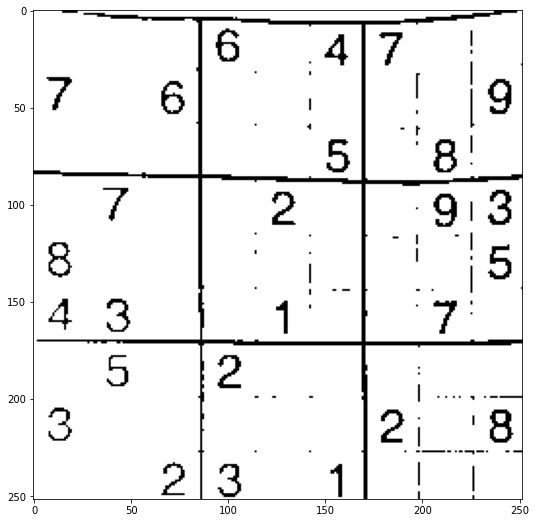

In [44]:
cv2_imshow(adaptive_threshold_cleanup(produce_transform('sudoku.jpeg', 9*28)))